In [1]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from mongo_db import MongoDB

"""
mong = MongoDB('lrc_price_snapshots')
col = mong.collection.find()
lrc_pricedata = pd.DataFrame(list(mong.collection.find()))
lrc_pricedata['created_at'] = pd.to_datetime(lrc_pricedata['created_at'], unit="s")

#startDate = pd.to_datetime('2022-09-21 23:30:00')
#lrc_pricedata = lrc_pricedata[pd.to_datetime(lrc_pricedata['created_at']) >= startDate]
lrc_pricedata.to_csv('lrc_snapshot_2_Nov_9_15.csv', sep=',')
"""

"""
btc_data = yf.download('BTC-USD', start='2016-01-01', end='2022-09-01')
stx_data = yf.download('STX-USD', start='2016-01-01', end='2022-09-01')
lrc_data = yf.download('LRC-USD', start='2016-01-01', end='2022-09-01')

btc_data.head()
stx_data.head()
lrc_data.head()
"""

2022-11-03 10:28:44.700177: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-03 10:28:44.702742: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-03 10:28:44.702751: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


"\nbtc_data = yf.download('BTC-USD', start='2016-01-01', end='2022-09-01')\nstx_data = yf.download('STX-USD', start='2016-01-01', end='2022-09-01')\nlrc_data = yf.download('LRC-USD', start='2016-01-01', end='2022-09-01')\n\nbtc_data.head()\nstx_data.head()\nlrc_data.head()\n"

In [2]:
pricedata = pd.read_csv('lrc_snapshot_2_Nov_9_15.csv', sep=',')

Text(0, 0.5, 'Prices ($)')

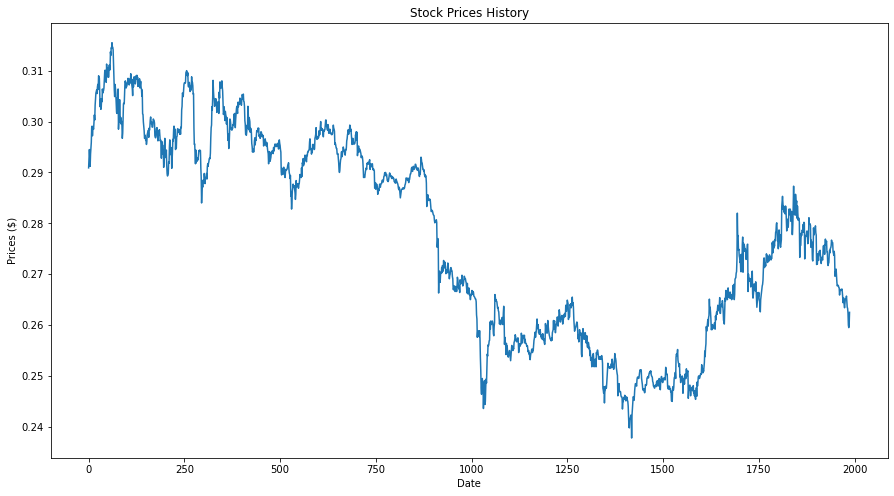

In [3]:
price_data_numeric = pd.to_numeric(pricedata['price'])
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(price_data_numeric)
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [4]:
close_prices = price_data_numeric
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(48, len(train_data)):
    x_train.append(train_data[i-48:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

Line 1–2: Extract the closing prices from the acquired stock data and convert it to a number series.

Line 3: Calculate the data size for 80% of the dataset. The math.ceil method is to ensure the data size is rounded up to an integer.

Line 5–6: Use the Scikit-Learn MinMaxScaler to normalize all our stock data ranging from 0 to 1. We also reshape our normalized data into a two-dimensional array.

Line 7: Set apart the first 80% of the stock data as the training set.

Line 9–10: Create an empty list for a sequence of feature data (x_train) and a sequence of label data (y_train).

Line 12–14: Create a 60-days window of historical prices (i-60) as our feature data (x_train) and the following 60-days window as label data (y_train).

Line 16–17: Convert the feature data (x_train) and label data (y_train) into Numpy array as it is the data format accepted by the Tensorflow when training a neural network model. Reshape again the x_train and y_train into a three-dimensional array as part of the requirement to train a LSTM model.

In [5]:
test_data = scaled_data[training_data_len-48: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(48, len(test_data)):
  x_test.append(test_data[i-48:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

Line 1: Extract the closing prices from our normalized dataset (the last 20% of the dataset).

Line 2–6: Similar to the training set, we will have to create feature data (x_test) and label data (y_test)from our test set.

Line 8–9: Convert the feature data (x_test) and label data (y_test) into Numpy array. Reshape again the x_test and y_test into a three-dimensional array

In [16]:
model = keras.Sequential()
print(x_train.shape[1])
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

48
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 48, 100)           40800     
                                                                 
 lstm_5 (LSTM)               (None, 100)               80400     
                                                                 
 dense_4 (Dense)             (None, 25)                2525      
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


Line 1: Define a Sequential model which consists of a linear stack of layers.

Line 2: Add a LSTM layer by giving it 100 network units. Set the return_sequence to true so that the output of the layer will be another sequence of the same length.

Line 3: Add another LSTM layer with also 100 network units. But we set the return_sequence to false for this time to only return the last output in the output sequence.

Line 4: Add a densely connected neural network layer with 25 network units.

Line 5: At last, add a densely connected layer that specifies the output of 1 network unit.

Line 6: Show the summary of our LSTM network architecture.

In [7]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 16, epochs=5)

Epoch 1/5
97/97 [==============================] - 3s 14ms/step - loss: 0.0123
Epoch 2/5
97/97 [==============================] - 1s 15ms/step - loss: 0.0011
Epoch 3/5
97/97 [==============================] - 2s 16ms/step - loss: 0.0011
Epoch 4/5
97/97 [==============================] - 1s 15ms/step - loss: 8.9133e-04
Epoch 5/5
97/97 [==============================] - 1s 14ms/step - loss: 9.2374e-04


Line 1: Adopt “adam” optimizer and set the mean square error as loss function.

Line 2: Train the model by fitting it with the training set. We can try with batch_size of 1 and run the training for 3 epochs.

In [15]:
predictions = model.predict(x_test)
print(len(predictions))
print(len(y_test))
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

13/13 [==============================] - 0s 7ms/step
397
397


0.034056517219663573

Line 1: Apply the model to predict the stock prices based on the test set.

Line 2: Use the inverse_transform method to denormalize the predicted stock prices.

Line 3–4: Apply the RMSE formula to calculate the degree of discrepancy between the predicted prices and real prices (y_test) and display the result.

397


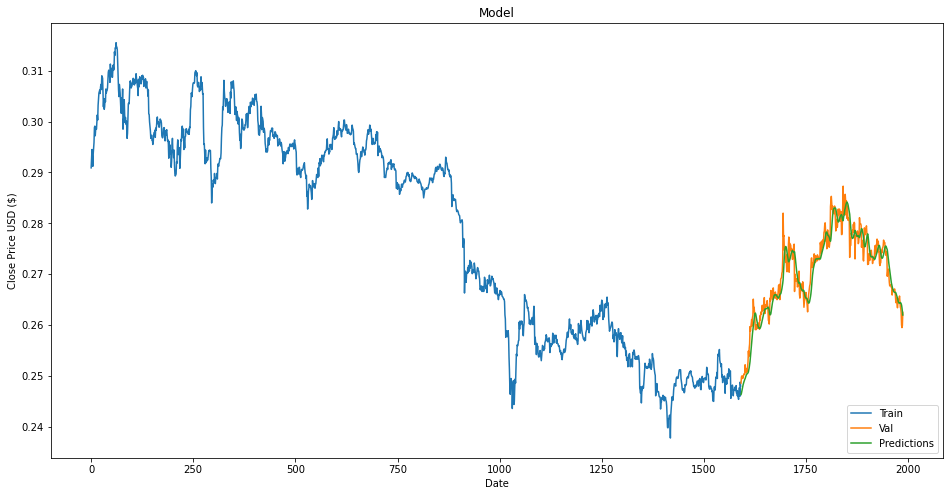

In [12]:
data = price_data_numeric
train = data[:training_data_len]
validation = pd.DataFrame()
validation['price'] = data[training_data_len:]
validation['Predictions'] = predictions
print(len(predictions))
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['price', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

Line 1: Use the filter method to only retain the closing price column in the dataframe.

Line 2–4: Split our stock data into three plotting regions: training, validation and prediction.

Line 5–12: Configure the chart figure size, title, x-axis & y-axis label and legends.

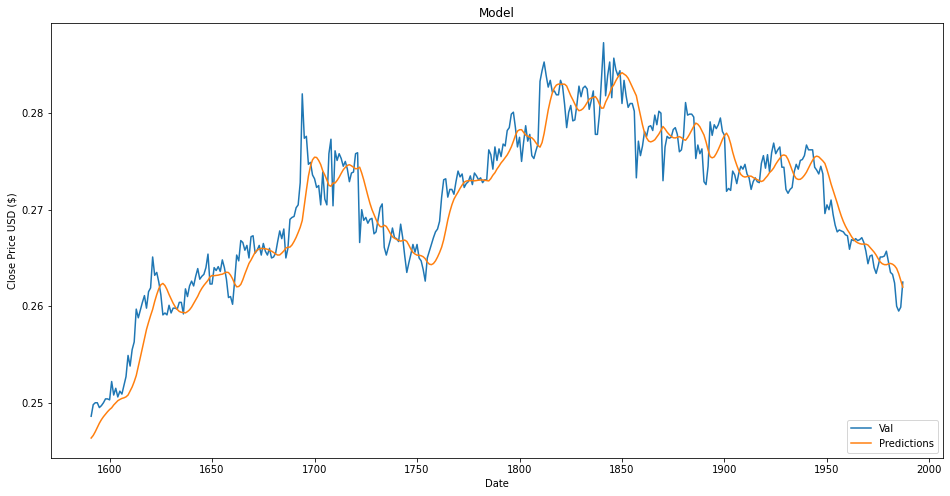

In [10]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(validation[['price', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()